In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

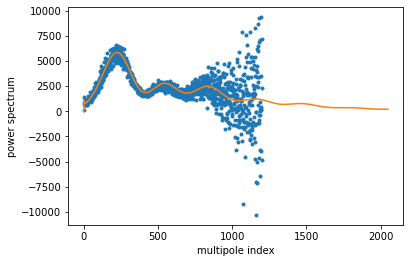

In [2]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

### 4) 
Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ. However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ. What are your parameter limits now? Please also present an argument as to why you think your chains are converged. As a reminder, you can draw samples of correlated data from a covariance matrix with   
r = np.linalg.cholesky(mat);   
d = np.dot(r, np.random.randn(r.shape[0])).    
You will want to use the covariance matrix from part 2) when drawing samples for the MCMC.

In [55]:
def ourfun(x,pars):
    #y=a sin(b/(x-c))+d
    y=pars[0]*np.sin(pars[1]/(x-pars[2]))+pars[3]
    return y

def cmbfun(x,pars):
    #call the cmb function with the current parameters
    y = wmap_camb_example.get_spectrum(pars, len(x))
    return y

def our_chisq(data,pars):
    #we need a function that calculates chi^2 for us for the MCMC
    #routine to call
    x=data[0]
    y=data[1]
    noise=data[2]
    
    if pars[3] < 0:
        chisq = np.inf
    else:
        model=cmbfun(x,pars)

        chisq=np.sum( (y-model)**2/noise**2)
    return chisq

In [56]:
# cmb=wmap_camb_example.get_spectrum(pars)

def run_mcmc(pars, data, par_step, chifun, nstep=5000):
    
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    
    chi_cur=chifun(data,pars)
    
    for i in range(nstep):
        
        pars_trial=pars+np.random.randn(npar)*par_step
        chi_trial=chifun(data,pars_trial)
        
        #we now have chi^2 at our current location
        #and chi^2 in our trial location. decide if we take the step
        accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
        if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
            pars=pars_trial
            chi_cur=chi_trial
        chain[i,:]=pars
        chivec[i]=chi_cur
        
        if i%1000==0:
            print("{:.2f} ".format(i/nstep), end = '')
    print("done")
    return chain,chivec

In [57]:
#y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]

x=np.linspace(1,10,1801)
print(len(x), x[-1])

# par_sigs=np.asarray([0.01,0.01,0.01,0.01])
par_sigs=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])/100

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars_guess=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

data=[wmap[:,0], wmap[:,1], wmap[:,2]]

chain,chivec=run_mcmc(pars_guess, data, par_sigs, our_chisq, nstep=30000)

pars_sigs_new=np.std(chain,axis=0)
print(pars_sigs_new)

1801 10.0


ValueError: operands could not be broadcast together with shapes (1199,) (1201,) 

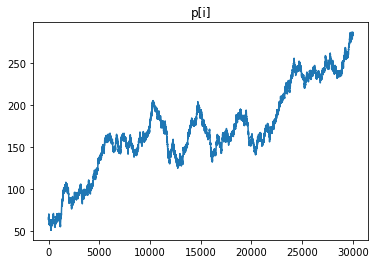

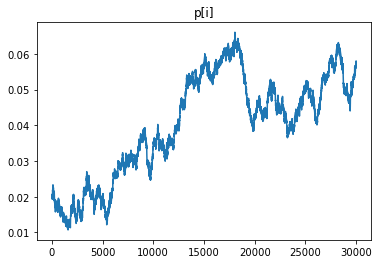

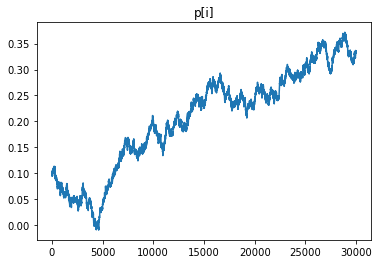

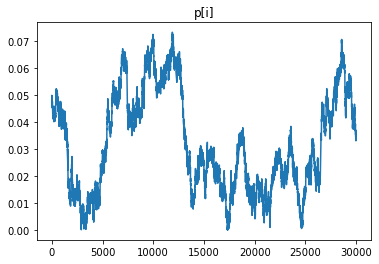

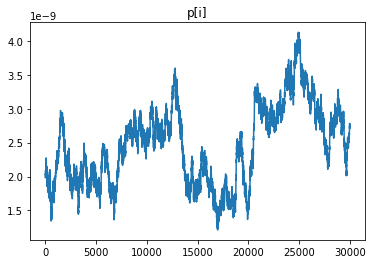

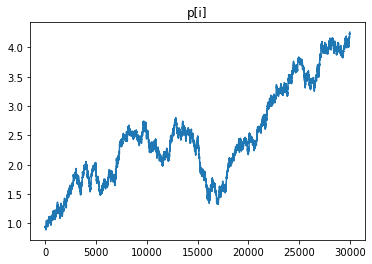

In [42]:
paths = np.transpose(chain)

for vchain in paths:
    plt.plot(vchain)
    plt.title("p[i]")
    plt.show()

In [ ]:
# chain2,chivec2=run_mcmc(pars,data,pars_sigs_new,our_chisq,nstep=20000)

# print('sigmas after first better chain are ',np.std(chain2,axis=0))
# pars_sigs_new=np.std(chain2,axis=0)
# pars=pars+5*np.random.randn(len(pars))*pars_sigs_new
# chain2,chivec2=run_mcmc(pars,data,pars_sigs_new,our_chisq,nstep=50000)

# param_errors=np.std(chain2,axis=0)
# print("sigmas after second better chain are ",param_errors)

# # # of sigmas our recovered parameters are off by truth is
# #(chain_mean - truth)/param_errors
# #this *ought* to be close to 1 on averag
# parameter_nsig=(np.mean(chain2,axis=0)-pars_true)/np.std(chain2,axis=0)
# print('we have parameter errors of ',parameter_nsig,' sigma')